In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.metrics import fbeta

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pathi = Path("../input/siic-isic-224x224-images")

In [4]:
pathc = Path("../input/melanomacsv")

In [5]:
train = pd.read_csv(pathc/'train.csv')
test = pd.read_csv(pathc/'test.csv')

In [6]:
train.head(4)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0


In [7]:
train.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

In [8]:
train['image_name'] = 'train/' + train['image_name'].astype(str) +'.png'
test['image_name'] = 'test/' + test['image_name'].astype(str) +'.png'

In [9]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,train/ISIC_2637011.png,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,train/ISIC_0015719.png,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,train/ISIC_0052212.png,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,train/ISIC_0068279.png,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,train/ISIC_0074268.png,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [10]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,test/ISIC_0052060.png,IP_3579794,male,70.0,NaN
1,test/ISIC_0052349.png,IP_7782715,male,40.0,lower extremity
2,test/ISIC_0058510.png,IP_7960270,female,55.0,torso
3,test/ISIC_0073313.png,IP_6375035,female,50.0,torso
4,test/ISIC_0073502.png,IP_0589375,female,45.0,lower extremity


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
labelcol=['image_name','target']
labels=train[labelcol]
labels.head(4)

,image_name,target
0,train/ISIC_2637011.png,0
1,train/ISIC_0015719.png,0
2,train/ISIC_0052212.png,0
3,train/ISIC_0068279.png,0


In [13]:
pathi

PosixPath('../input/siic-isic-224x224-images')

In [14]:
np.random.seed(42)
data = ImageDataBunch.from_df(pathi, labels, ds_tfms=get_transforms(), size=224, bs=64 )
data.normalize(imagenet_stats)
test_data = ImageList.from_df(test,pathi)
data.add_test(test_data)
data

ImageDataBunch;

Train: LabelList (26501 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: ../input/siic-isic-224x224-images;

Valid: LabelList (6625 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: ../input/siic-isic-224x224-images;

Test: LabelList (10982 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../input/siic-isic-224x224-images

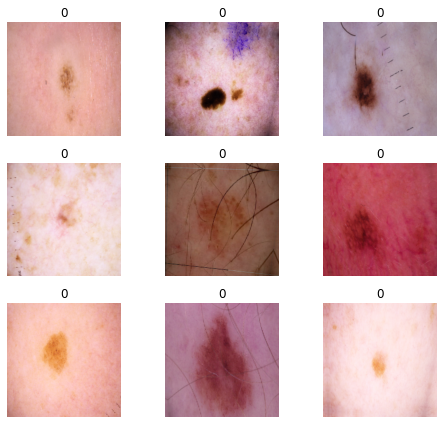

In [15]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes)
len(data.classes)

[0, 1]


2

In [17]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
from fastai.metrics import Precision , accuracy , Recall
from  fastai.metrics import AUROC

In [18]:
pr=Precision()
re=Recall()
aur=AUROC()

In [19]:
#import torch.pretrained
#import torchvision.models as models
#inceptionModel = models.inception_v3(pretrained=True)

In [20]:
#model_name = 'inception_v3' # could be fbresnet152 or inceptionresnetv2
#model = models.__dict__[model_name](num_classes=2, pretrained='imagenet')


In [21]:
learn = cnn_learner(data, models.resnet152 , metrics=aur )

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [22]:
learn.model.cuda();
import torch
torch.cuda.device(0)

In [23]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [25]:
#train
from fastai.utils.mem import GPUMemTrace
with GPUMemTrace():
    learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,auroc,time
0,0.201144,0.108049,0.537466,06:27
1,0.088234,0.091059,0.761695,05:46
2,0.075554,0.084721,0.808989,05:48
3,0.070370,0.083941,0.833839,05:50
4,0.072065,0.073908,0.858823,05:50
5,0.070987,0.073496,0.869672,05:53
6,0.059035,0.075696,0.870307,05:54
7,0.056792,0.074720,0.870159,05:56


△Used Peaked MB:    122 14,796 (exit)


In [26]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

Exception: [Errno 30] Read-only file system: '../input/siic-isic-224x224-images/models'
Can't write to '../input/siic-isic-224x224-images/models', set `learn.model_dir` attribute in Learner to a full libpath path that is writable

*UNFREEZE*

In [27]:
learn.unfreeze()
from fastai.utils.mem import GPUMemTrace
with GPUMemTrace():
    learn.fit_one_cycle(4,max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,auroc,time
0,0.075896,0.081664,0.840378,06:22
1,0.069225,0.073625,0.857964,06:28
2,0.065032,0.073836,0.887828,06:31
3,0.045568,0.071497,0.879974,06:31


△Used Peaked MB:  2,180 11,480 (exit)


In [ ]:
learn.freeze()
from fastai.utils.mem import GPUMemTrace
with GPUMemTrace():
    learn.fit_one_cycle(4,max_lr=slice(3e-5,3e-4))

**TEST**

In [28]:
predictions, *_ = learn.get_preds(DatasetType.Test)
#labels = np.argmax(predictions, 1)

In [29]:
ans =predictions[:,1]
ans

tensor([4.9892e-04, 7.1248e-07, 2.1164e-06,  ..., 9.1402e-03, 1.1255e-04,
        1.2207e-03])

In [30]:
sub=pd.read_csv("../input/submission/sample_submission.csv")
sub

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0
...,...,...
10977,ISIC_9992485,0
10978,ISIC_9996992,0
10979,ISIC_9997917,0
10980,ISIC_9998234,0


In [31]:
pred=pd.DataFrame(ans)
sub['target']=pred
sub.head()

,image_name,target
0,ISIC_0052060,4.989150e-04
1,ISIC_0052349,7.124806e-07
2,ISIC_0058510,2.116355e-06
3,ISIC_0073313,1.853478e-04
4,ISIC_0073502,7.287078e-04


In [32]:
sub.to_csv('res152-6.4.csv',index=False)